In [1]:
import pandas as pd
from auto_ml_regression.preprocessing import DataPreprocessor

data = pd.read_csv('../../datasets/insurance_dataset/insurance.csv')
target_col="charges"
N_SEGMENTS = 2

cat_features = data.select_dtypes(include='object').columns.to_list()
num_features = data.select_dtypes(exclude='object').columns.to_list()
num_features.remove(target_col)
cat_features_saved = [f'CAT_{i}' for i in cat_features]

# Инициализация и применение препроцессора
preprocessor = DataPreprocessor(
    target_col=target_col,
    cat_encoder_type="target",  # или "target"
    fillna_num_strategy="mean",
    scaler_type="minmax",
    test_size=0.33,
    random_state=2025,
)

train_df, test_df = preprocessor.fit_transform(data)

/Users/andrejurkinair/Documents/diploma_practice/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-05-17 17:06:58,613] A new study created in memory with name: no-name-44d61bee-b805-4adc-821b-0dc41ceaff97
[I 2025-05-17 17:07:01,050] Trial 0 finished with value: -10632.961650413885 and parameters: {'depth': 2, 'learning_rate': 0.19967490119672932, 'l2_leaf_reg': 1.3509629057655352}. Best is trial 0 with value: -10632.961650413885.
[I 2025-05-17 17:07:01,735] Trial 1 finished with value: -11115.780934975905 and parameters: {'depth': 2, 'learning_rate': 0.12931076715129328, 'l2_leaf_reg': 1.7586770564716412}. Best is trial 0 with value: -10632.961650413885.
[I 2025-05-17 17:07:01,758] Trial 2 finished with value: -10014.978670490053 and parameters: {'depth': 3, 'learning_rate': 0.24897100123709

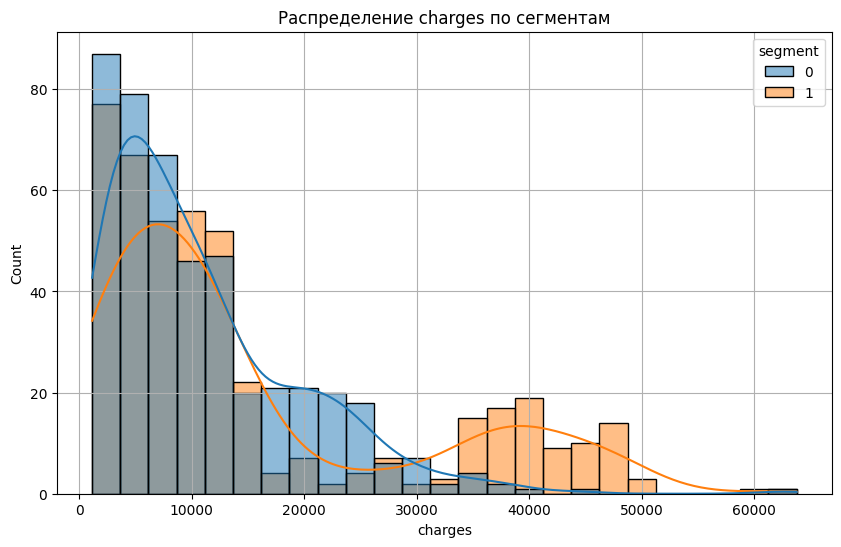

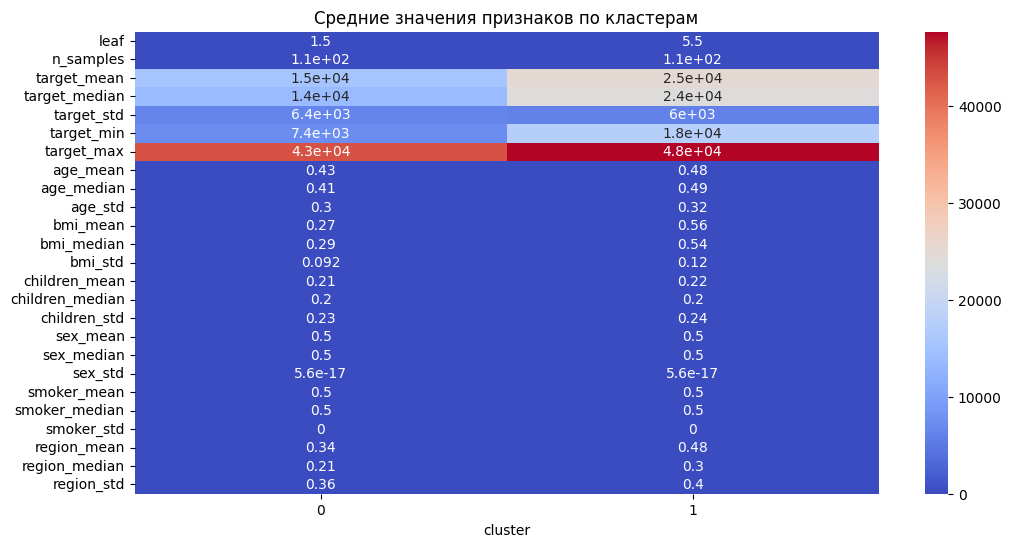

In [2]:
from auto_ml_regression.segmentation.ctb_kmeans import CatBoostLeafSegmenter

segmenter = CatBoostLeafSegmenter(
    features=num_features+cat_features,
    target_col=target_col,
    n_segments=N_SEGMENTS,
    depth=3,
    use_optuna=True,
    n_trials=30,
    plot=True
)
# Обучение
segmented_train = segmenter.fit(train_df)

In [4]:
segmenter.predict(test_df)

,age,sex,bmi,children,smoker,region,CAT_sex,CAT_smoker,CAT_region,charges
0,0.586957,1.0,0.318338,0.6,0.0,0.301857,male,no,southwest,8615.30000
1,0.000000,0.0,0.696261,0.0,0.0,0.209375,female,no,northeast,2217.46915
2,0.739130,1.0,0.744377,0.4,1.0,1.000000,male,yes,southeast,47269.85400
3,0.869565,1.0,0.401907,0.0,0.0,0.209375,male,no,northeast,11938.25595
4,0.500000,1.0,0.602860,0.4,0.0,0.000000,male,no,northwest,7265.70250
...,...,...,...,...,...,...,...,...,...,...
437,0.043478,1.0,0.331149,0.0,0.0,0.209375,male,no,northeast,1967.02270
438,0.913043,1.0,0.350961,0.0,0.0,0.209375,male,no,northeast,30259.99556
439,0.521739,0.0,0.701773,0.4,1.0,1.000000,female,yes,southeast,43896.37630
440,0.173913,1.0,0.479219,0.4,1.0,0.301857,male,yes,southwest,36085.21900


In [4]:
from auto_ml_regression.modeling.classifier import SegmentClassifier
from sklearn import metrics
import numpy as np

clf = SegmentClassifier(
    features=num_features+cat_features_saved,
    cat_features=cat_features_saved, 
    n_segments=N_SEGMENTS
)

# Обучаем на сегментированных данных
clf.fit(
    X=segmented_train[num_features+cat_features_saved],
    y=segmented_train['segment'],
    n_trials=5  # Количество итераций Optuna
)


[I 2025-05-17 17:07:43,933] A new study created in memory with name: no-name-2ea1e9a4-d052-4d0e-9d82-460e4f807e38
[I 2025-05-17 17:07:44,500] Trial 0 finished with value: 1.0 and parameters: {'iterations': 894, 'learning_rate': 0.09467175738413298, 'l2_leaf_reg': 0.2772920655307119, 'random_strength': 0.9927763336493316, 'bagging_temperature': 3.62668880994819, 'border_count': 141, 'min_data_in_leaf': 81, 'leaf_estimation_iterations': 6, 'grow_policy': 'Depthwise', 'od_type': 'IncToDec', 'od_wait': 11, 'one_hot_max_size': 129, 'max_depth': 10}. Best is trial 0 with value: 1.0.
[I 2025-05-17 17:07:44,814] Trial 1 finished with value: 1.0 and parameters: {'iterations': 1518, 'learning_rate': 0.1949795441602036, 'l2_leaf_reg': 0.004406683128049792, 'random_strength': 0.011713546023711881, 'bagging_temperature': 1.8811572319859216, 'border_count': 78, 'min_data_in_leaf': 97, 'leaf_estimation_iterations': 6, 'grow_policy': 'Depthwise', 'od_type': 'IncToDec', 'od_wait': 48, 'one_hot_max_size

Classification Report: TRAIN
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       450
           1       1.00      1.00      1.00       446

    accuracy                           1.00       896
   macro avg       1.00      1.00      1.00       896
weighted avg       1.00      1.00      1.00       896

ROC AUC = 1.0


In [5]:
# 3. Предсказание на тестовых данных
# Сначала сегментируем тестовые данные (используем тот же segmenter)
segmented_test = segmenter.predict(test_df)
# Предсказание сегментов
test_segment_probs = clf.model.predict_proba(segmented_test[num_features+cat_features_saved])
test_segments = clf.model.predict(segmented_test[num_features+cat_features_saved])
segmented_test['segment_probs'] = test_segment_probs[:, 1]
segmented_test['segment_preds'] = test_segments 

print(f"TEST ROC AUC - {metrics.roc_auc_score(segmented_test['segment'], test_segment_probs[:, 1], multi_class='ovr')}")#[:, 1]


TEST ROC AUC - 1.0


In [6]:
from auto_ml_regression.modeling.linear_regs import SegmentLinearModels

lr = SegmentLinearModels(features=num_features+cat_features,
                         model_type='huber',
                         use_optuna=True,
                         n_trials=50,
                         cv=4)
lr.fit(segmented_train, 
       segmented_train['charges'], 
       segments=segmented_train['segment'])

[I 2025-05-17 17:07:50,770] A new study created in memory with name: no-name-433f7e06-176f-4e22-ac2b-83f4d38c08aa
[I 2025-05-17 17:07:50,800] Trial 0 finished with value: -11349.199906929052 and parameters: {'epsilon': 3.8663035758356874, 'alpha': 0.20311377712065443, 'fit_intercept': False}. Best is trial 0 with value: -11349.199906929052.
[I 2025-05-17 17:07:50,822] Trial 1 finished with value: -11499.708681685359 and parameters: {'epsilon': 6.524546061888747, 'alpha': 0.24194801534907956, 'fit_intercept': False}. Best is trial 0 with value: -11349.199906929052.
[I 2025-05-17 17:07:50,841] Trial 2 finished with value: -10901.039764173507 and parameters: {'epsilon': 1.3754116476812028, 'alpha': 0.14793934786393784, 'fit_intercept': False}. Best is trial 2 with value: -10901.039764173507.
[I 2025-05-17 17:07:50,861] Trial 3 finished with value: -11616.533767502298 and parameters: {'epsilon': 7.058748252402731, 'alpha': 0.2846735108389523, 'fit_intercept': False}. Best is trial 2 with v

In [7]:
lr.get_model_coefs()

,model_coef_segment_0,model_coef_segment_1
intercept_,902.170678,420.590214
age,11826.554718,12650.004654
bmi,7275.374709,2914.581291
children,1247.514961,4037.490208
sex,-263.444206,-490.153375
smoker,15006.036362,32521.111748
region,-932.072084,-80.028397


In [38]:
test_target_preds = lr.predict(segmented_test, 
                              segments=segmented_test['segment_preds'],
                              )
                              # use_weighted=True,
                              # segment_probs=test_segment_probs

test_target_true = segmented_test.charges

In [39]:
lr.get_model(0).feature_names_in_

array(['age', 'bmi', 'children', 'sex', 'smoker', 'region'], dtype=object)

In [40]:
r2 = metrics.r2_score(test_target_true, test_target_preds)
mse = metrics.mean_squared_error(test_target_true, test_target_preds)
mae = metrics.mean_absolute_error(test_target_true, test_target_preds)
mape = metrics.mean_absolute_percentage_error(test_target_true, test_target_preds)

print(f"R2 = {r2}")
print(f"MSE = {mse}")
print(f"RMSE = {mse**0.5}")
print(f"MAE = {mae}")
print(f"MAPE = {mape}")

R2 = 0.8502970987756149
MSE = 22407129.804375574
RMSE = 4733.6169896154015
MAE = 2166.4512802959666
MAPE = 0.1724370931438519
